### Filters applied 

- **Start year ≥ 2000** – drop any trial that began before 1 Jan 2000  
- **Enrolment ≥ 10 participants** – exclude studies that planned or enrolled fewer than 10 subjects *or* have missing enrolment information  
- **Duration ≤ 10 years** – remove trials whose actual duration exceeds 3 650 days  
- **Completion date is in the past** – keep only records with a non-null primary/overall completion date that is **≤ today**  
- **Completion type = ACTUAL & status ∈ {Completed, Terminated}** – discard trials that report only an *anticipated* finish date or are still recruiting/suspended


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from IPython.display import display

# Load the data
df = pd.read_parquet("../data/processed/features_v1.parquet")

# Total number of studies (rows) and features (columns)
n_studies = df.shape[0]
n_features = df.shape[1]
print(f"Total number of studies: {n_studies}")
print(f"Total number of features: {n_features}\n")

# Number of numeric vs. categorical columns
n_numeric = df.select_dtypes(include=np.number).shape[1]
n_categorical = df.select_dtypes(include=['object', 'category']).shape[1]
print(f"Numeric columns: {n_numeric}")
print(f"Categorical (object/category) columns: {n_categorical}\n")



Total number of studies: 281548
Total number of features: 42

Numeric columns: 9
Categorical (object/category) columns: 31



<class 'pandas.core.frame.DataFrame'>
Int64Index: 281548 entries, 0 to 538872
Data columns (total 39 columns):
 #   Column                                                                                           Non-Null Count   Dtype         
---  ------                                                                                           --------------   -----         
 0   indication/disease area                                                                          281548 non-null  object        
 1   rare, non-rare (established disease area and clear diagnosis criteria)                           242807 non-null  object        
 2   mode of administration (ex. NBE, NCE, iv vs pill)                                                257335 non-null  object        
 3   disease modifying or treating symptoms                                                           218664 non-null  object        
 4   population - adults vs peds                                                     

None

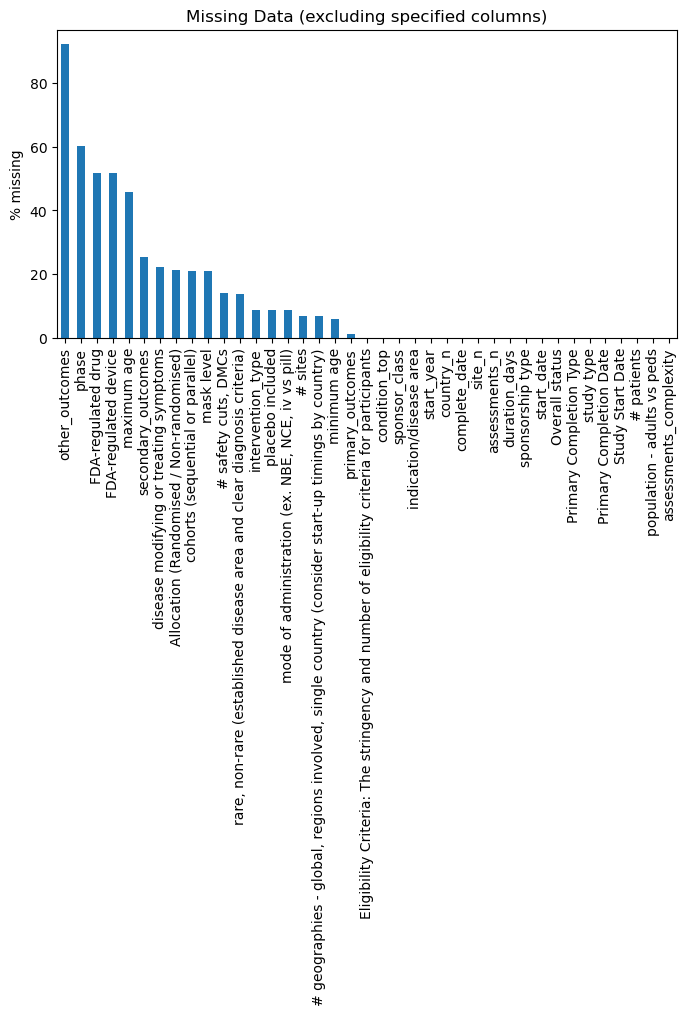

,missing_rows,pct_missing
other_outcomes,259475,92.160129
phase,169441,60.181923
FDA-regulated drug,145789,51.781224
FDA-regulated device,145765,51.772700
maximum age,129171,45.878855
secondary_outcomes,71345,25.340262
disease modifying or treating symptoms,62884,22.335090
Allocation (Randomised / Non-randomised),59544,21.148792
cohorts (sequential or parallel),59507,21.135650
mask level,59368,21.086280


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

# Load the data
df = pd.read_parquet("../data/processed/features_v1.parquet")

# Make a temporary copy and replace "Unknown" in phase with NaN
tmp = df.copy()
if "phase" in tmp.columns:
    tmp.loc[tmp["phase"] == "Unknown", "phase"] = pd.NA   # or np.nan

# Drop the specified columns before computing missingness
cols_to_drop = [
    "safety events",
    "evaluability / drop out rate",
    "screen fail rate"
]
tmp = tmp.drop(columns=cols_to_drop, errors="ignore")

# Standard DataFrame info with counts
display(tmp.info(show_counts=True))

# Missing-percentage bar plot (excluding the dropped columns)
miss = tmp.isna().mean().sort_values(ascending=False) * 100
miss.head(40).plot.bar(figsize=(8, 4))
plt.ylabel("% missing")
plt.title("Missing Data (excluding specified columns)")
plt.show()

# Table with absolute & % missing (excluding the dropped columns)
miss_tbl = pd.DataFrame({
    "missing_rows": tmp.isna().sum(),
    "pct_missing":  miss
}).sort_values("pct_missing", ascending=False)

display(miss_tbl.head(40))  # show top-40 variables (excluding dropped columns)


## Trials per Phase


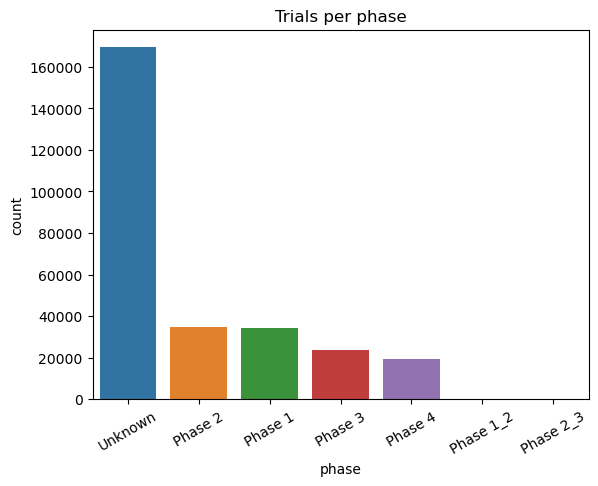

In [17]:
sns.countplot(data=df, x="phase", order=df["phase"].value_counts().index)
plt.xticks(rotation=30); plt.title("Trials per phase"); plt.show()

## Duration by phase 

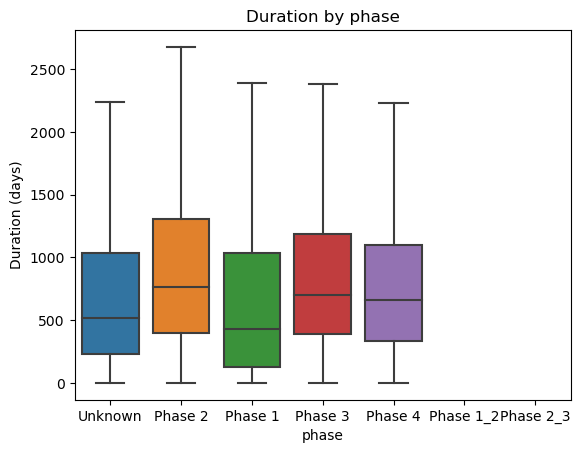

In [18]:
sns.boxplot(data=df, x="phase", y="duration_days",
            order=df["phase"].value_counts().index, showfliers=False)
plt.ylabel("Duration (days)"); plt.title("Duration by phase"); plt.show()

## Duration by Phase and Sponsor Class


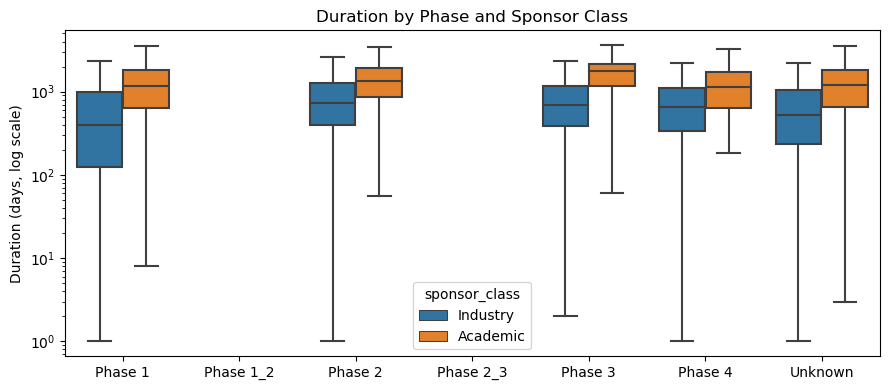

In [19]:
plt.figure(figsize=(9,4))
sns.boxplot(data=df, x="phase", y="duration_days",
            hue="sponsor_class", showfliers=False,
            order=["Phase 1","Phase 1_2","Phase 2","Phase 2_3","Phase 3","Phase 4","Unknown"])
plt.yscale("log")
plt.title("Duration by Phase and Sponsor Class")
plt.ylabel("Duration (days, log scale)")
plt.xlabel("")
plt.tight_layout(); plt.show()


## Trial Duration by Start Year 


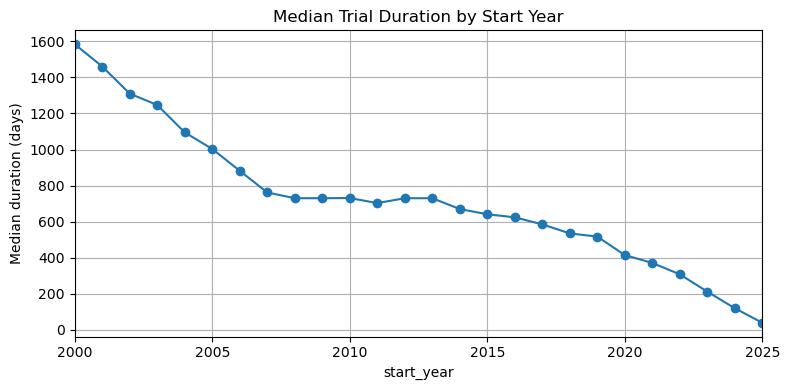

In [51]:
# keep only trials between 1980 and 2025
lower_year = 2000
cutoff_year = 2025
# Filter rows whose start_year is in the desired interval
mask = (df["start_year"] >= lower_year) & (df["start_year"] <= cutoff_year)
df_plot = df[mask]

# Plot median duration by start year
ax = (df_plot.groupby("start_year")["duration_days"]
          .median()
          .plot(marker="o", figsize=(8, 4)))

ax.set_ylabel("Median duration (days)")
ax.set_title("Median Trial Duration by Start Year")
ax.set_xlim(lower_year, cutoff_year)   # keep the x-axis tight to the interval
ax.grid(True)
plt.tight_layout()
plt.show()


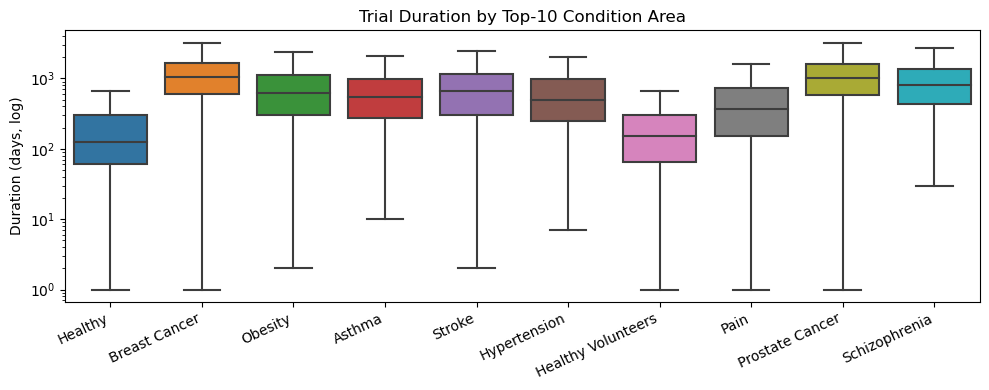

In [21]:
top10 = df["condition_top"].value_counts().index[:10]
sub   = df[df["condition_top"].isin(top10)]

plt.figure(figsize=(10,4))
sns.boxplot(data=sub, x="condition_top", y="duration_days",
            showfliers=False,
            order=top10)
plt.yscale("log")
plt.xticks(rotation=25, ha="right"); plt.xlabel("")
plt.ylabel("Duration (days, log)")
plt.title("Trial Duration by Top-10 Condition Area")
plt.tight_layout(); plt.show()


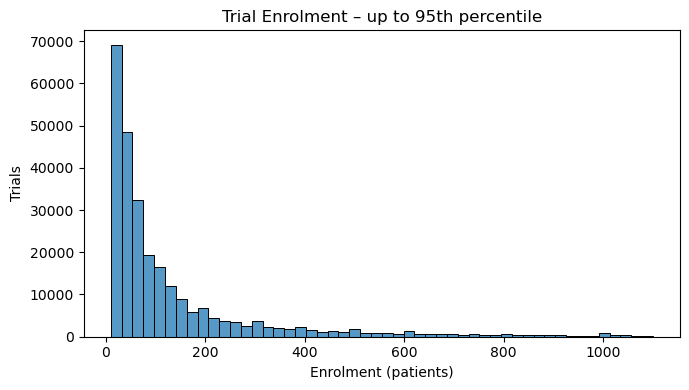

Trials above the cap: 14042


In [8]:
cap = np.percentile(df["# patients"].dropna(), 95)    # ≈ 99th-percentile
trunc = df[df["# patients"] <= cap]["# patients"]

plt.figure(figsize=(7,4))
sns.histplot(trunc, bins=50, kde=False)
plt.xlabel("Enrolment (patients)")
plt.ylabel("Trials")
plt.title("Trial Enrolment – up to 95th percentile")
plt.tight_layout(); plt.show()

print("Trials above the cap:", (df["# patients"] > cap).sum())


In [4]:
import pandas as pd
import numpy as np
from IPython.display import display

# ---- descriptive statistics -----------------------------------
desc = df["# patients"].describe(percentiles=[.01,.05,.25,.5,.75,.95]).to_frame()
desc.rename(columns={"# patients": "patients"}, inplace=True)  # nicer header
desc.loc["variance"] = df["# patients"].var()
desc.loc["std dev"]  = df["# patients"].std()

# round large integers for readability
desc = desc.applymap(lambda x: f"{int(x):,}" if pd.notna(x) else x)

print("Enrolment – descriptive statistics")
display(desc)

# ---- summary of extreme tail -----------------------------------
cap = np.percentile(df["# patients"].dropna(), 95)
above_cap = df[df["# patients"] > cap].shape[0]

print(f"\n95th-percentile (cap) : {cap:,.0f} patients")
print(f"Trials above cap      : {above_cap:,}")


Enrolment – descriptive statistics


,patients
count,"281,548"
mean,"3,937"
std,"407,304"
min,10
1%,10
5%,14
25%,32
50%,68
75%,180
95%,"1,100"



95th-percentile (cap) : 1,100 patients
Trials above cap      : 14,042


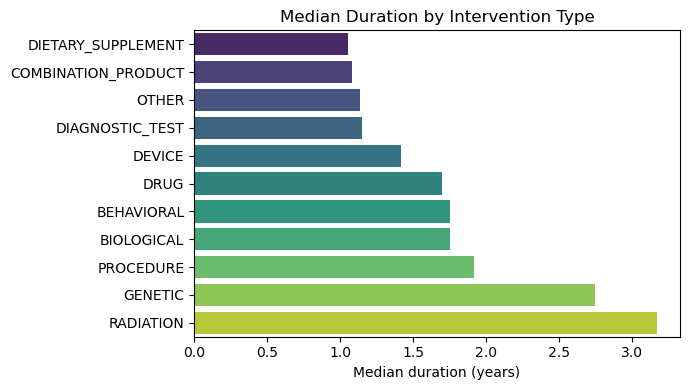

In [16]:
# count top N types
topn = df["intervention_type"].value_counts().head(12).index
sub  = df[df["intervention_type"].isin(topn)]

pivot = (sub.groupby("intervention_type")
              ["duration_days"].median()
              .sort_values())            # ascending for nicer y-axis

plt.figure(figsize=(7,4))
sns.barplot(x=pivot.values/365.25,   # convert to years
            y=pivot.index, palette="viridis")
plt.xlabel("Median duration (years)"); plt.ylabel("")
plt.title("Median Duration by Intervention Type")
plt.tight_layout(); plt.show()


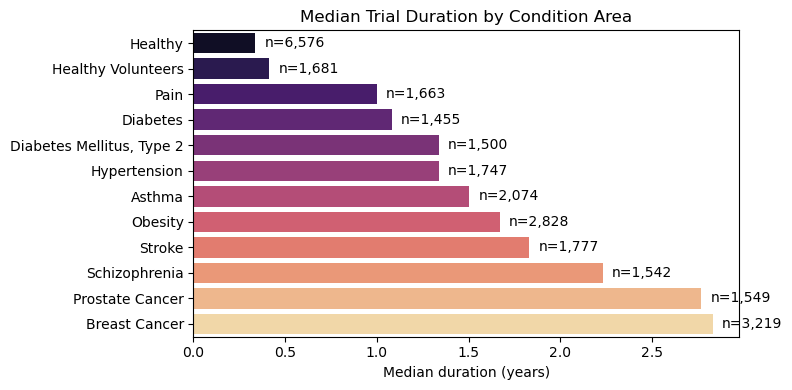

In [21]:
# --- top 12 condition areas ----------------------------------------
topn_cond = df["condition_top"].value_counts().head(12).index
sub_cond  = df[df["condition_top"].isin(topn_cond)]

# --- median duration (years) & sort --------------------------------
cond_median = (sub_cond.groupby("condition_top")["duration_days"]
               .median()
               .sort_values()) / 365.25   # convert to years
order = cond_median.index

# --- bar plot -------------------------------------------------------
plt.figure(figsize=(8,4))
ax = sns.barplot(x=cond_median.values,
                 y=order,
                 palette="magma")
plt.xlabel("Median duration (years)")
plt.ylabel("")
plt.title("Median Trial Duration by Condition Area")

# --- annotate n on each bar ----------------------------------------
for i, cond in enumerate(order):
    n = sub_cond[sub_cond["condition_top"] == cond].shape[0]
    ax.text(cond_median[cond] + 0.05,          # x-pos just past bar end
            i,                                 # y-pos at bar centre
            f"n={n:,}",
            va="center")

plt.tight_layout(); plt.show()


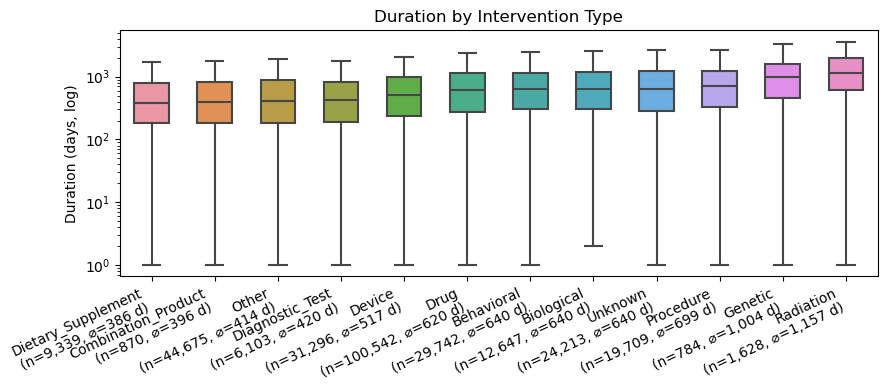

In [19]:
# ------------------------------------------------------------------
# 1.  derive a clean first-level intervention label
# ------------------------------------------------------------------
if "intervention_top" not in df.columns:
    df["intervention_top"] = (
        df["intervention_type"]          # e.g. "Drug|Small molecule|Oral"
          .fillna("Unknown")
          .str.split("|").str[0]         # take first token only
          .str.title()
    )

# ------------------------------------------------------------------
# 2.  order categories by their median duration
# ------------------------------------------------------------------
median_days = (df.groupby("intervention_top")["duration_days"]
                 .median()
                 .sort_values())            # ascending for tidy y-axis
order = median_days.index

# ------------------------------------------------------------------
# 3.  box-and-whisker plot
# ------------------------------------------------------------------
plt.figure(figsize=(9,4))
sns.boxplot(data=df, x="intervention_top", y="duration_days",
            order=order, showfliers=False, width=0.55)
plt.yscale("log")
plt.ylabel("Duration (days, log)")
plt.xlabel("")
plt.title("Duration by Intervention Type")

# add n and median duration below each tick
ticks = [f"{m}\n(n={df[df['intervention_top']==m].shape[0]:,}, "
         f"⌀={int(median_days[m]):,} d)"
         for m in order]
plt.xticks(range(len(order)), ticks, rotation=25, ha="right")
plt.tight_layout(); plt.show()


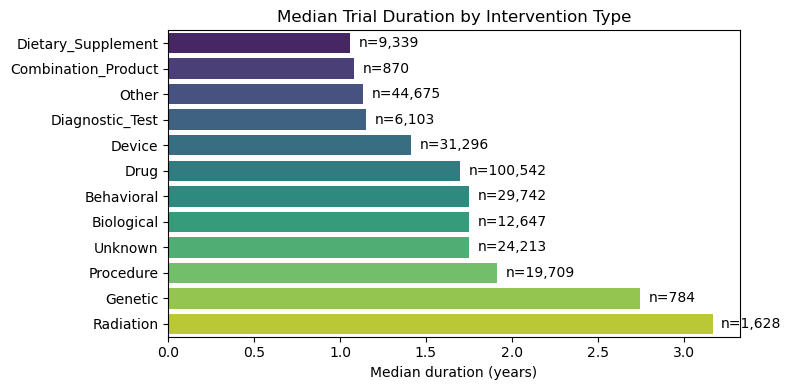

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ------------------------------------------------------------------
# 1. tidy first-level intervention label
# ------------------------------------------------------------------
if "intervention_top" not in df.columns:
    df["intervention_top"] = (
        df["intervention_type"]
          .fillna("Unknown")
          .str.split("|").str[0]
          .str.title()
    )

# ------------------------------------------------------------------
# 2. keep the 12 most common categories
# ------------------------------------------------------------------
top12 = df["intervention_top"].value_counts().head(12).index
sub   = df[df["intervention_top"].isin(top12)]

# median duration (years) for sort order
median_years = (
    sub.groupby("intervention_top")["duration_days"]
        .median()
        .sort_values()
        / 365.25
)

# ------------------------------------------------------------------
# 3. bar-plot
# ------------------------------------------------------------------
plt.figure(figsize=(8,4))
sns.barplot(
    x=median_years.values,
    y=median_years.index,
    palette="viridis"
)
plt.xlabel("Median duration (years)")
plt.ylabel("")
plt.title("Median Trial Duration by Intervention Type")

# annotate each bar with n
for i, (name, med) in enumerate(median_years.items()):
    n = sub[sub["intervention_top"] == name].shape[0]
    plt.text(med + 0.05, i, f"n={n:,}", va="center")

plt.tight_layout(); plt.show()


In [25]:
import pyarrow.parquet as pq, pprint

# option 1 – fastest: read only the schema
schema = pq.read_schema("../data/processed/features_v1.parquet")
cols   = schema.names

# option 2 – load a tiny row group (safe if file is modest size)
# cols = pq.read_table("../data/processed/features_v1.parquet").schema.names

pprint.pprint(cols)
print("Total columns:", len(cols))


['indication/disease area',
 'rare, non-rare (established disease area and clear diagnosis criteria)',
 'mode of administration (ex. NBE, NCE, iv vs pill)',
 'disease modifying or treating symptoms',
 'population - adults vs peds',
 'phase',
 '# patients',
 'primary_outcomes',
 'secondary_outcomes',
 'other_outcomes',
 'cohorts (sequential or parallel)',
 'Eligibility Criteria: The stringency and number of eligibility criteria for '
 'participants',
 'placebo included',
 '# safety cuts, DMCs',
 '# geographies - global, regions involved, single country (consider start-up '
 'timings by country)',
 '# sites',
 'Study Start Date',
 'Primary Completion Date',
 'mask level',
 'sponsorship type',
 'study type',
 'minimum age',
 'maximum age',
 'Allocation (Randomised / Non-randomised)',
 'FDA-regulated drug',
 'FDA-regulated device',
 'Primary Completion Type',
 'Overall status',
 'start_date',
 'complete_date',
 'duration_days',
 'sponsor_class',
 'condition_top',
 'intervention_type',
 'st